# BTC/USD forecast 

In [116]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


# Task

In [13]:
data = pd.read_csv('BTC-USD_daily.csv', delimiter=',', index_col=['Date'], parse_dates=['Date'],dayfirst=False)

In [14]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [15]:
data.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
data.head()

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [38]:
data.dropna(inplace=True)

In [39]:
data.isna().sum()

Close      0
btc_box    0
dtype: int64

In [16]:
data.index1

DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21',
               '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
               '2021-02-26', '2021-02-27'],
              dtype='datetime64[ns]', name='Date', length=2356, freq=None)

In [65]:
data.shape

(2352, 5)

In [7]:
data.tail()

,Close
Date,
2021-02-23,48824.425781
2021-02-24,49705.332031
2021-02-25,47093.851563
2021-02-26,46339.761719
2021-02-27,47098.253906


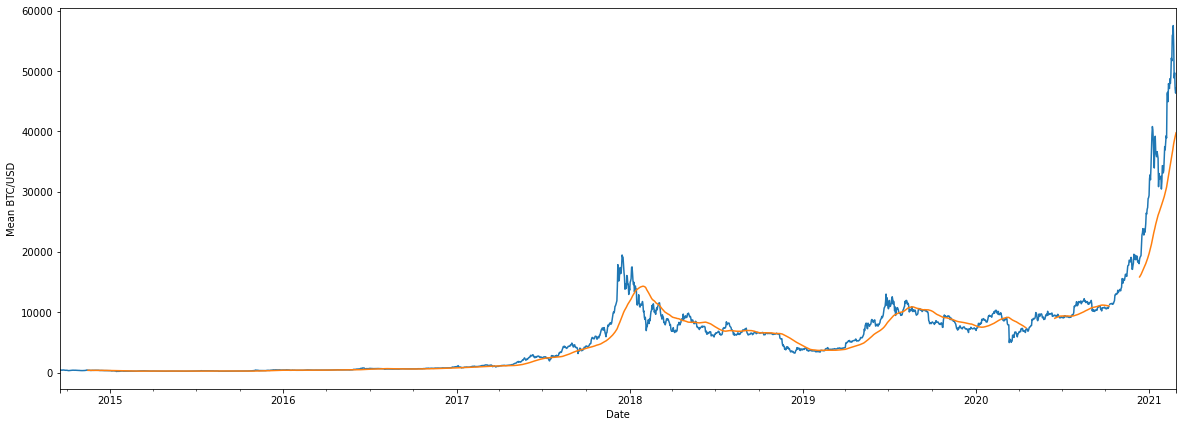

In [21]:
plt.figure(figsize(20,7))
data.Close.plot()
data.rolling(window=60).mean()['Close'].plot()
plt.ylabel('Mean BTC/USD')
pylab.show()

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

## Part 1: Визуальный анализ ряда

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=1.000000


<Figure size 1080x720 with 0 Axes>

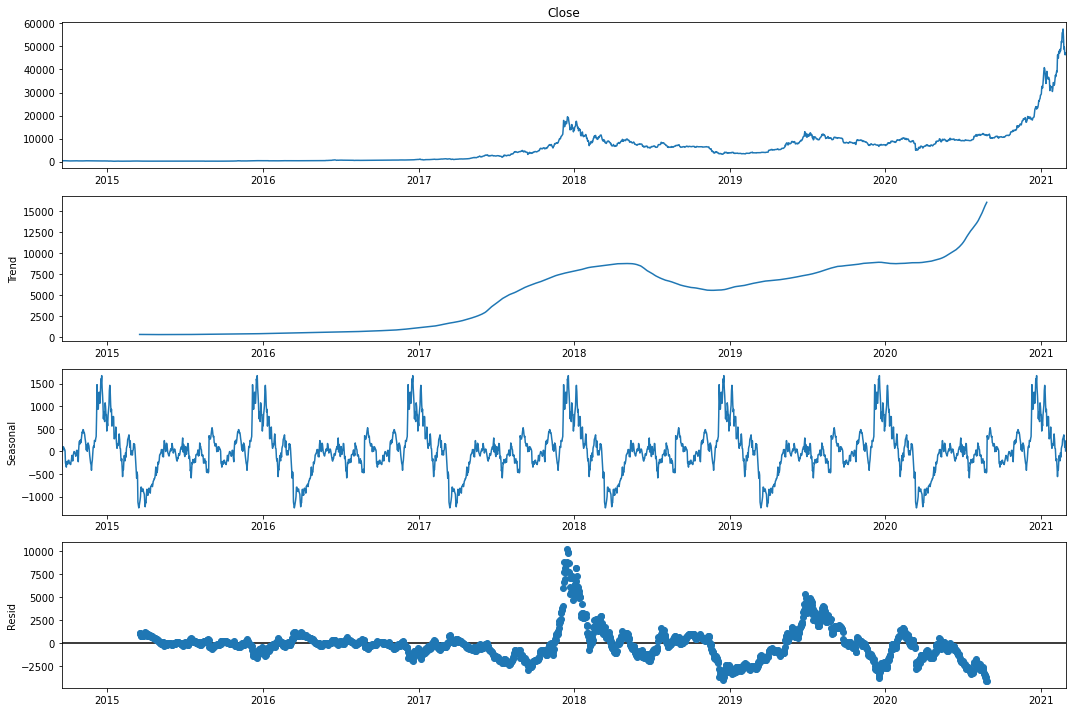

In [40]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.Close.dropna(), period=365).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Close.dropna())[1])

## Part 2: Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

In [42]:
data['btc_box'], lmbda = stats.boxcox(data.Close) # Возвращает ряд после преобразования и лямбда критерий

Построим график ряда после преобразования Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.104776
Критерий Дики-Фуллера: p=0.983667


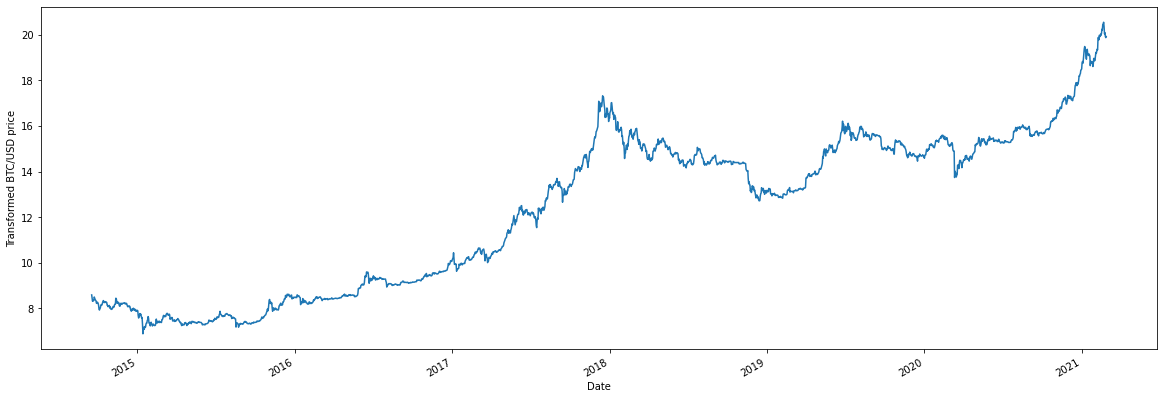

In [43]:
plt.figure(figsize(20,7))
data.btc_box.plot()
plt.ylabel(u'Transformed BTC/USD price')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.btc_box)[1])

## Part 3: Выбор порядка дифференцирования (стационарность)

Критерий Дики-Фуллера отвергает гипотезу стационарности, и визуально в данных виден тренд. Попробуем для начала сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

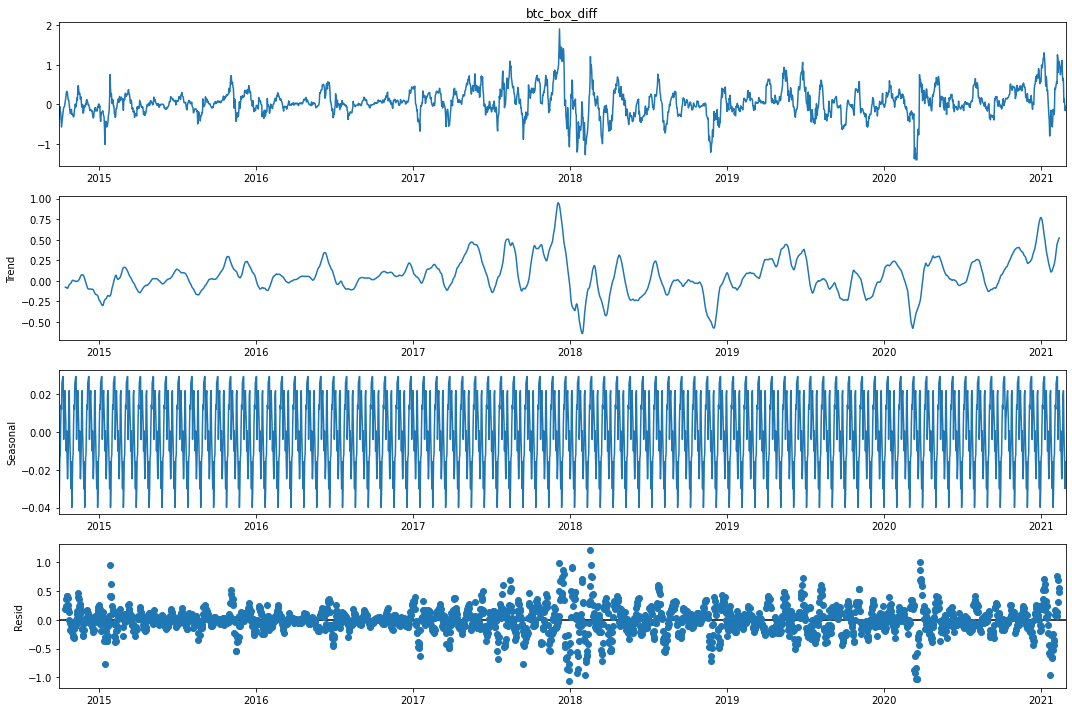

In [47]:
data['btc_box_diff'] = data.btc_box - data.btc_box.shift(12)

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.btc_box_diff[12:], period=30).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.btc_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

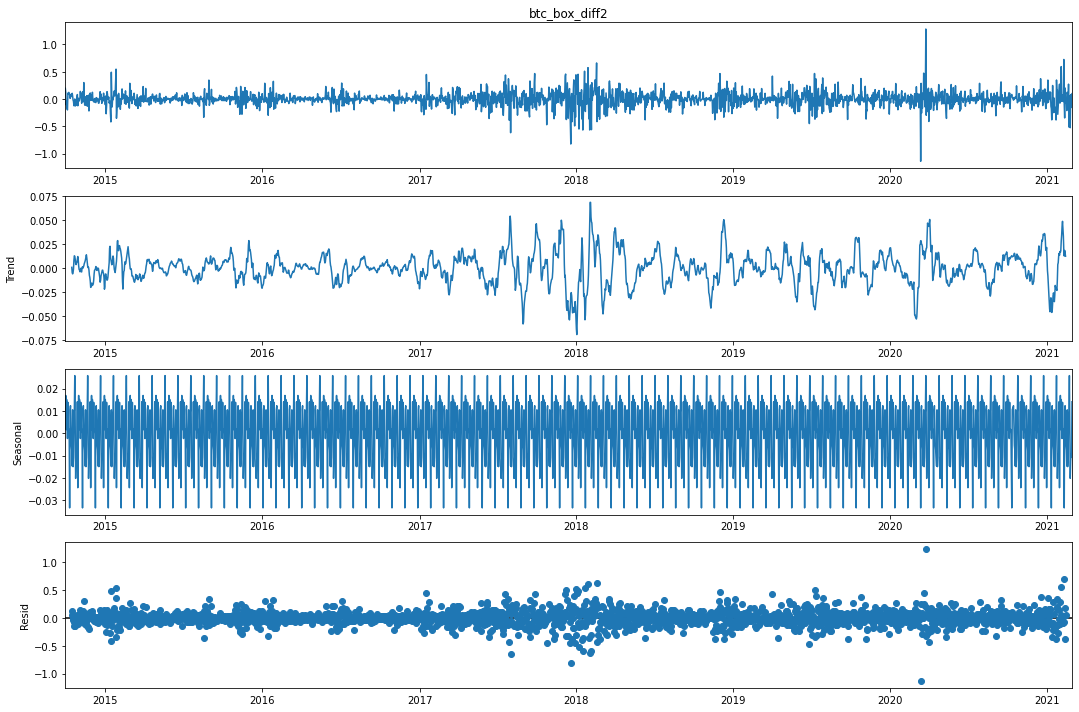

In [48]:
data['btc_box_diff2'] = data.btc_box_diff - data.btc_box_diff.shift(1)

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.btc_box_diff2[13:], period=30).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.btc_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Part 4: Выбор начальных приближений для $p,q,P,Q$

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

In [53]:
data.head(20)

,Close,btc_box,btc_box_diff,btc_box_diff2
Date,,,,
2014-09-17,457.334015,8.588703,NaN,NaN
2014-09-18,424.440002,8.447442,NaN,NaN
2014-09-19,394.795990,8.311475,NaN,NaN
2014-09-20,408.903992,8.377284,NaN,NaN
2014-09-21,398.821014,8.330463,NaN,NaN
2014-09-22,402.152008,8.346046,NaN,NaN
2014-09-23,435.790985,8.497262,NaN,NaN
2014-09-24,423.204987,8.441950,NaN,NaN
2014-09-25,411.574005,8.389509,NaN,NaN


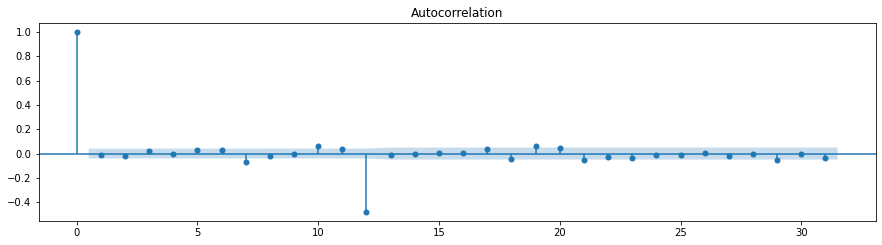

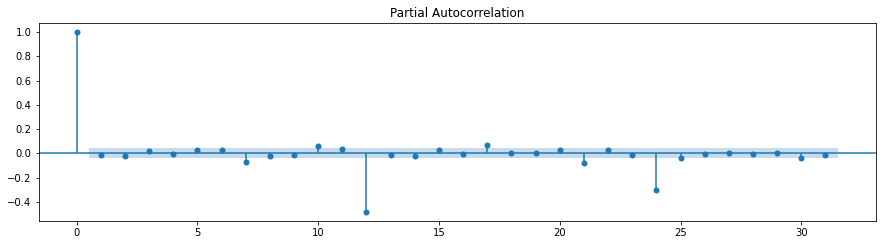

In [49]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.btc_box_diff2[13:].values.squeeze(), lags=31, ax=ax)
pylab.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.btc_box_diff2[13:].values.squeeze(), lags=31, ax=ax)
pylab.show()

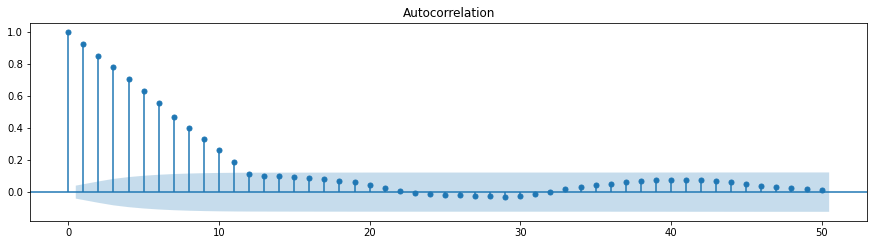

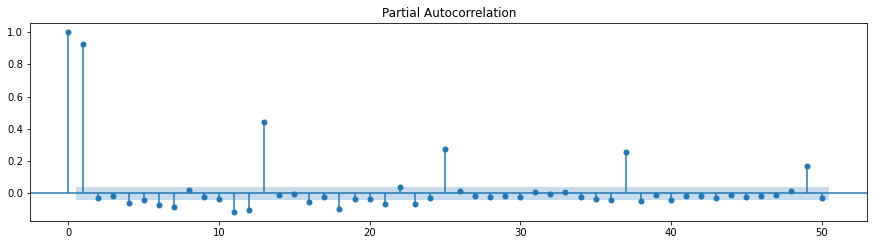

In [55]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.btc_box_diff[12:].values.squeeze(), lags=50, ax=ax)
pylab.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.btc_box_diff[12:].values.squeeze(), lags=50, ax=ax)
pylab.show()

Начальные приближения: $Q=0, q=11, P=1, p=11$

In [56]:
ps = range(0, 12) # from partial autocorrelation
d=0 # simple diffences 
qs = range(0, 12) # from autocorrelation

Ps = range(0, 2) # from partial autocorrelation
D=1 # season diffences 
Qs = range(0, 1) # from autocorrelation

In [57]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

288

## Part 5: Обучение и сравнение моделей-кандидатов, выбор победителя

In [58]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.btc_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

KeyboardInterrupt: 

Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [59]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

        parameters          aic
22   (0, 11, 0, 0) -4318.804254
23   (0, 11, 1, 0) -4315.915478
214  (8, 11, 0, 0) -4312.488638
46   (1, 11, 0, 0) -4312.400337
71   (2, 11, 1, 0) -4309.645742


Лучшая модель:

In [60]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              btc_box   No. Observations:                 2352
Model:             SARIMAX(0, 0, 11)x(0, 1, [], 12)   Log Likelihood                2171.402
Date:                              Sat, 27 Feb 2021   AIC                          -4318.804
Time:                                      20:29:55   BIC                          -4249.709
Sample:                                           0   HQIC                         -4293.635
                                             - 2352                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9963      0.039     25.856      0.000       0.921       1.072
ma.L2          0.99

## Part 6: Анализ остатков построенной модели

при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения $p,q,P,Q$

Критерий Стьюдента: p=0.010887
Критерий Дики-Фуллера: p=0.000000


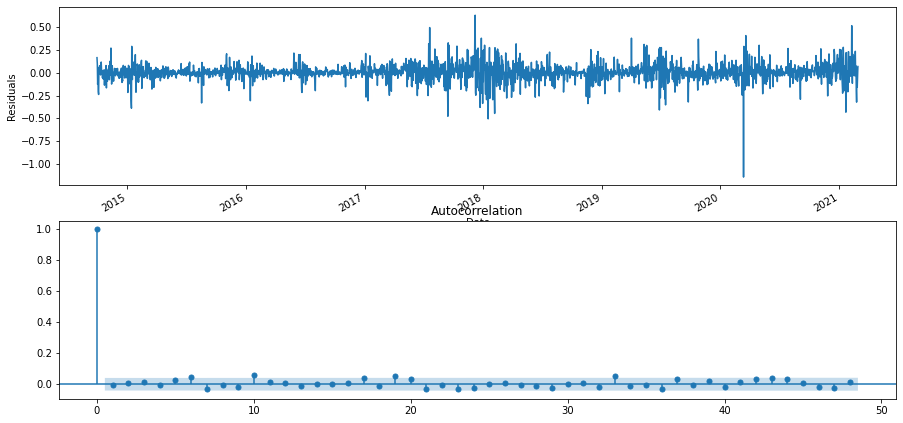

In [61]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

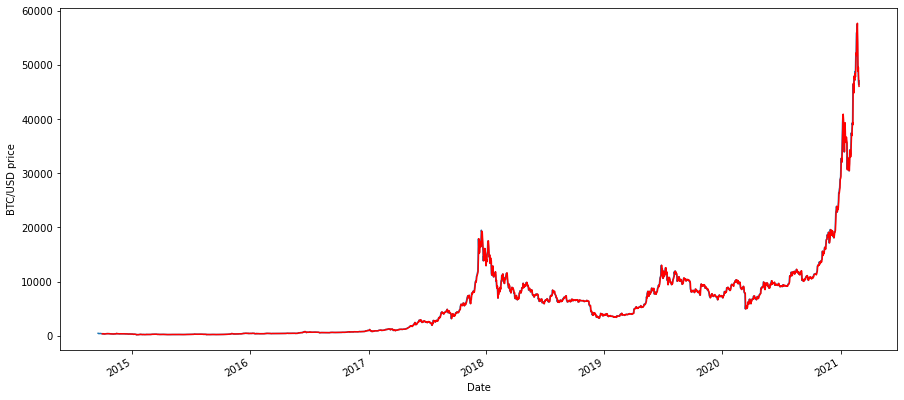

In [62]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.Close.plot()
data.model[13:].plot(color='r')
plt.ylabel('BTC/USD price')
pylab.show()

## Part 7: Прогнозирование с помощью финальной модели.

In [94]:
len(data.index)

2352

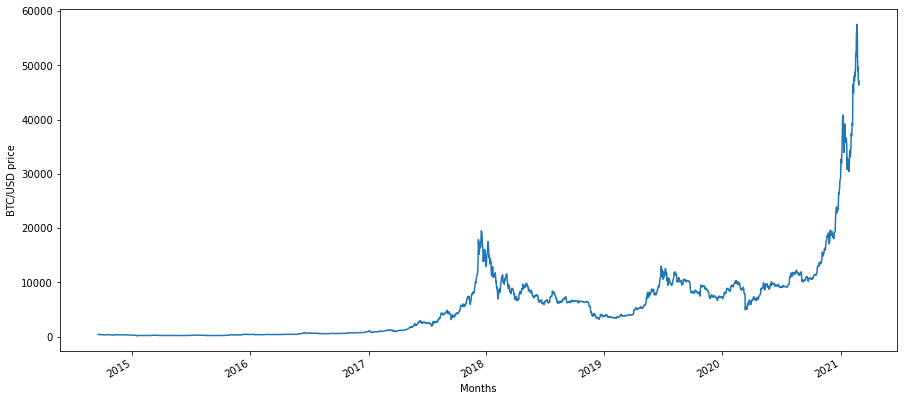

In [130]:
data2 = data[['Close']]
date_list = [datetime.datetime.strptime("2021-02-27", "%Y-%m-%d") + relativedelta(days=x) for x in range(0,365)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2.loc[2352:, 'forecast'] = invboxcox(best_model.forecast(365), lmbda).loc[0:365]

plt.figure(figsize(15,7))
data2.Close.plot()
data2.forecast.plot(color='red')
plt.ylabel('BTC/USD price')
plt.xlabel('Months')
pylab.show()